# Project: Wrangling and Analyze Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import requests
import json as js
import io
import os

%matplotlib inline

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [ ]:
#import the twitter archive
df_twitter_archive = pd.read_csv('./twitter-archive-enhanced.csv')

In [ ]:
#confirm results
df_twitter_archive.head()

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [87]:
#Setup requests for read
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
urlData = requests.get(url).content

#Read into a dataframe with correct encoding
df_tweet_image = pd.read_csv(io.StringIO(urlData.decode('utf-8')))

#Split into meaningful data, and remove original blob column
df_tweet_image[['tweet_id','tjpg_url', 'timg_num', 'tp1','tp1_conf', 'tp1_dog', 'tp2', 'tp2_conf', 'tp2_dog', 'tp3', 'tp3_conf', 'tp3_dog']] = df_tweet_image['tweet_id	jpg_url	img_num	p1	p1_conf	p1_dog	p2	p2_conf	p2_dog	p3	p3_conf	p3_dog'].str.split(pat='\t', n=12, expand=True)
df_tweet_image.drop('tweet_id	jpg_url	img_num	p1	p1_conf	p1_dog	p2	p2_conf	p2_dog	p3	p3_conf	p3_dog', axis=1, inplace=True)


SSLError: HTTPSConnectionPool(host='d17h27t6h515a5.cloudfront.net', port=443): Max retries exceeded with url: /topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)')))

In [ ]:
#confirm results
df_tweet_image.head()

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)
**NOTE:** function source is attributed to the site StackOverflow: https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

In [ ]:
# Read Tweets into a text file, one time run (DO NOT RERUN - REMOVE KEYS)
CONSUMER_KEY = 'REMOVED'
CONSUMER_SECRET = 'REMOVED'
OAUTH_TOKEN = 'REMOVED'
OAUTH_TOKEN_SECRET = 'REMOVED'
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

# inspect Tweets and save to file.
print('Starting Dump of in scope tweet stats')

# list comprehension includes: tweet.id_str | tweet.text | tweet.favorite_count | tweet.retweet_count| tweet.user.followers_count | tweet.user.friends_count | tweet.user.favourites_count
# Loop the list and push to the file with updates to the user.
# Open file
file_input = open("tweet_json.csv","w")

# Write Header
record = '{}|{}|{}|{}|{}|{}|{}\n'.format('id_str', 'text', 'favorite_count','retweet_count', 'followers_count', 'friends_count', 'favourites_count')
file_input.write(record)
print("Output Written: {}".format(record))

#Write Records
for i in pd_twitter_archive.tweet_id:
    try:
        tweet = api.get_status(i)
        print(str(tweet.id) + ' downloaded')
        record = '{}|{}|{}|{}|{}|{}|{}\n'.format(tweet.id_str, tweet.text, tweet.favorite_count, tweet.retweet_count, tweet.user.followers_count, tweet.user.friends_count, tweet.user.favourites_count)
        file_input.write(record)
        print("Output Written: {}".format(record))
    except:
        print('No Match - Skipping {}'.format(i))
        
#Close file and finish
file_input.close()
print('Dump compete and file closed')


In [88]:
# Read tweet_json.txt file directly into a pandas dataframe
df_tweets_enhanced = pd.read_csv('tweet_json.csv', sep='|')

In [89]:
# Confirm Results
df_tweets_enhanced.head(5)

,id_str,text,favorite_count,retweet_count,followers_count,friends_count,favourites_count
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,"33,674","6,964","9,364,491",21,"147,637"
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boop… https://t.co/aQFSeaCu9L","29,214","5,269","9,364,491",21,"147,637"
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike.… https://t.co/r0YlrsGCgy,"21,962","3,463","9,364,491",21,"147,637"
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,"36,768","7,190","9,364,491",21,"147,637"
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected a… https://t.co/0g0KMIVXZ3","35,161","7,710","9,364,491",21,"147,637"


**Additional data from the Twitter API**
Gather each tweet's retweet count and favorite ("like") count at the minimum and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file.

Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [ ]:
#review the shape of the data
# Twitter Archive
print(df_twitter_archive.shape)

# Twitter Image Analysis
print(df_tweet_image.shape)
#print(df_tweet_image.info())

# Twitter Enhanced
print(df_tweets_enhanced.shape)

In [ ]:
# Confirm df_tweets_enhanced success, first should show 35, then 908
regex_string = r"^([0-9][0-9][0-9][0-9][0-9][0-9]*)"
print(df_tweets_enhanced[~df_tweets_enhanced["id_str"].str.contains(regex_string, na=False, regex=True)]['id_str'].count())
print(df_tweets_enhanced[~df_tweets_enhanced["id_str"].isnull()]['id_str'].count())

In [ ]:
# confirm any values newer than 2017-08-01 to exclude, should be no lines returned.
df_twitter_archive['timestamp'] = pd.to_datetime(df_twitter_archive['timestamp'], format='%Y-%m-%d')
df_twitter_archive.loc[df_twitter_archive['timestamp'] > '2017-08-02']


In [ ]:
#Assess the twitter retweets
df_twitter_archive[(~df_twitter_archive['retweeted_status_id'].isnull())].count()


In [ ]:
# Detect the duplicates (retweets) in the tjpg_url
print(df_tweet_image['tjpg_url'].count()-df_tweet_image['tjpg_url'].nunique())

#Detect the duplicates (retweets) in the expanded_urls
print(df_twitter_archive['expanded_urls'].count()-df_twitter_archive['expanded_urls'].nunique())

['timestamp', 'source', 'text', 'retweeted_status_timestamp', 'expanded_urls', 'name', 'doggo', 'floofer', 'pupper', 'puppo']






















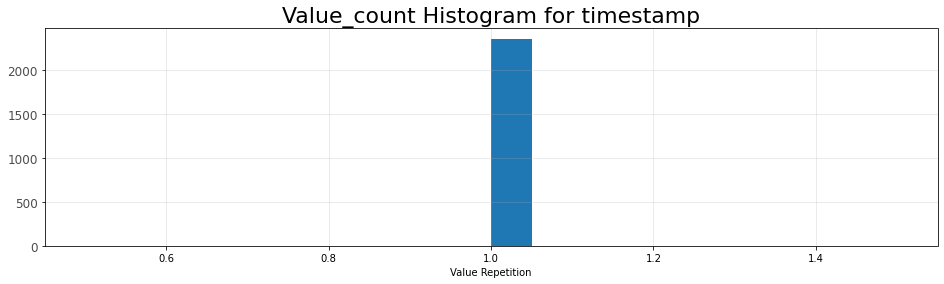

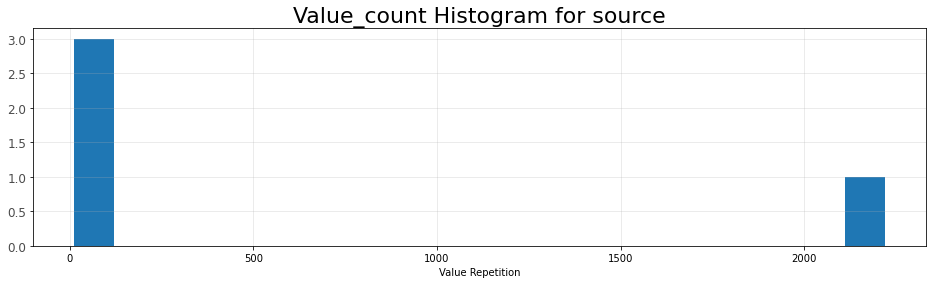

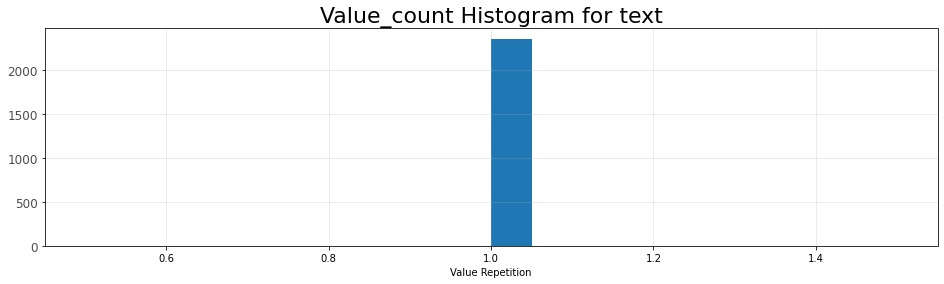

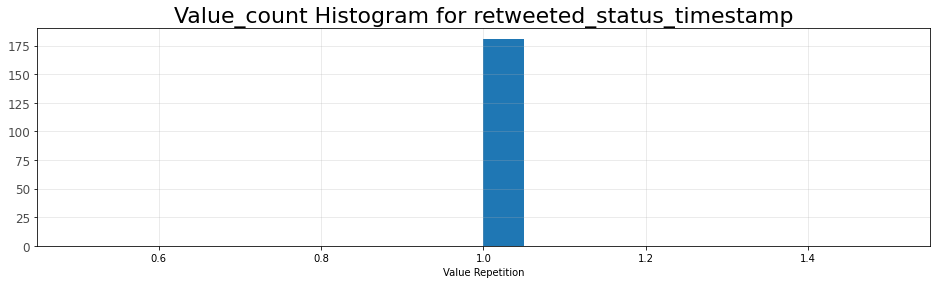

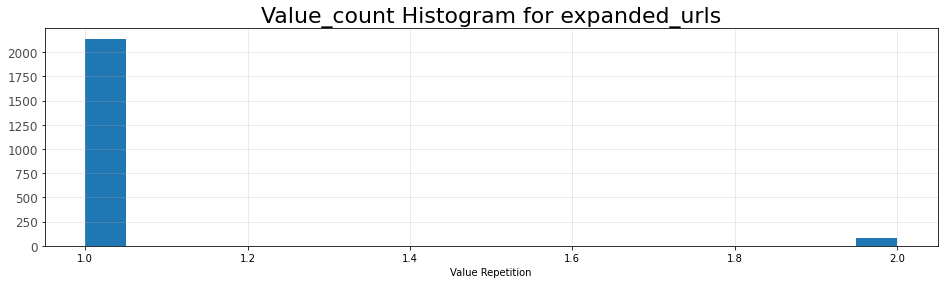

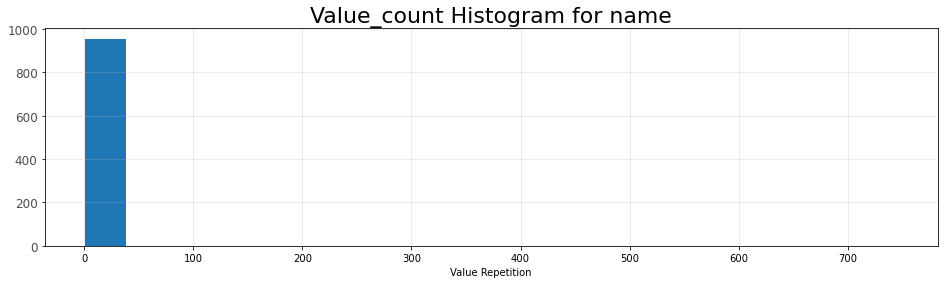

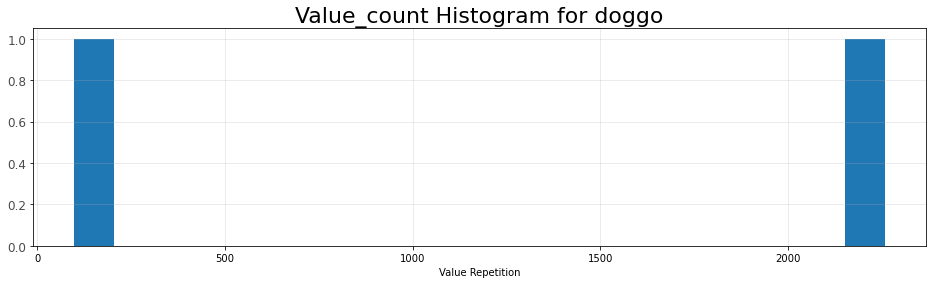

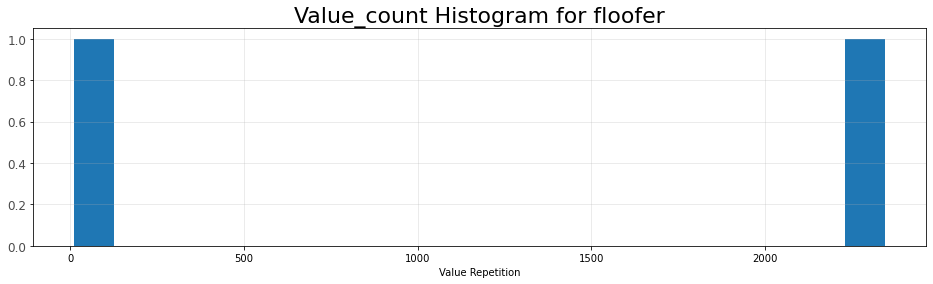

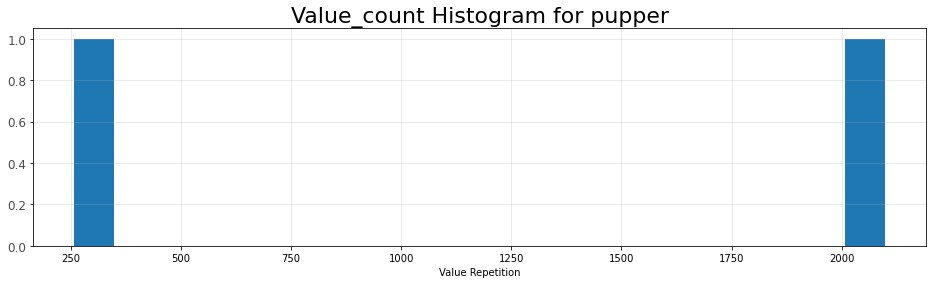

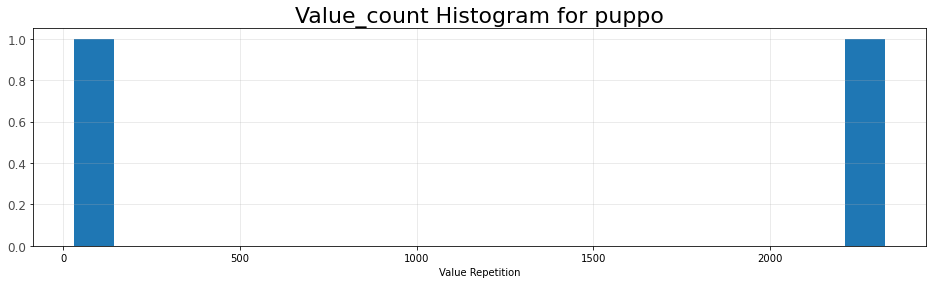

In [90]:
# Histogram for each column, statistical value distributions and visual data inspection for string columns in df_twitter_archive
list = []
for column in df_twitter_archive.columns:
    if str(df_twitter_archive[column].dtype) == "object":
        list.append(column)
print(list)

for column in list:
    fig = plt.figure(figsize = (16,4))
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Value Repetition')
    plt.title('Value_count Histogram for '+ column, fontsize=22)
    plt.grid(axis='both', alpha=.3)
    ax = fig.gca()
    df_twitter_archive[column].value_counts().hist(ax = ax, bins=20)
    print('\n')

In [ ]:
# Histogram for each column, statistical value distributions and visual data inspection for string columns in df_tweet_image
list = []
for column in df_tweet_image.columns:
    if str(df_tweet_image[column].dtype) == "object":
        list.append(column)
print(list)

for column in list:
    fig = plt.figure(figsize = (16,4))
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Value Repetition')
    plt.title('Value_count Histogram for '+ column, fontsize=22)
    plt.grid(axis='both', alpha=.3)
    ax = fig.gca()
    df_tweet_image[column].value_counts().hist(ax = ax, bins=20)
    print('\n')

['id_str', 'text']






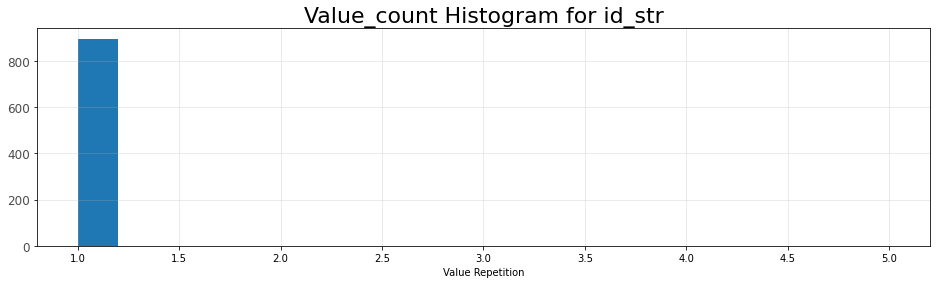

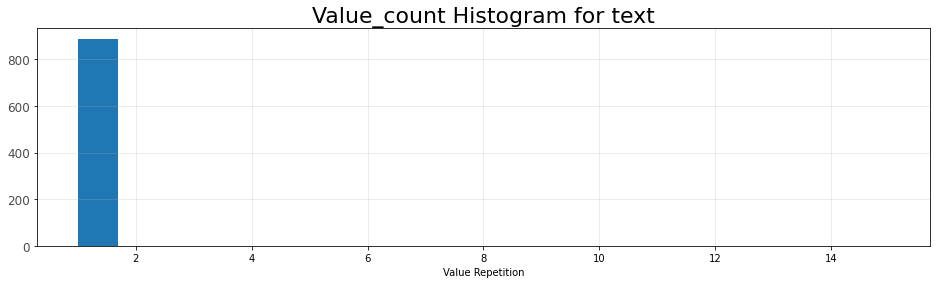

In [91]:
# Histogram for each column, statistical value distributions and visual data inspection for string columns in df_tweets_enhanced
list = []
for column in df_tweets_enhanced.columns:
    if str(df_tweets_enhanced[column].dtype) == "object":
        list.append(column)
print(list)

for column in list:
    fig = plt.figure(figsize = (16,4))
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Value Repetition')
    plt.title('Value_count Histogram for '+ column, fontsize=22)
    plt.grid(axis='both', alpha=.3)
    ax = fig.gca()
    df_tweets_enhanced[column].value_counts().hist(ax = ax, bins=20)
    print('\n')

### Value_count Histogram Obserations
1. We see a clear decline in the tpX_conf (confidence) values as they go from high order to low order ML assessment.
2. The tweet_id, name, text_x and text_y are clearly not duplcated, as all values have a value_count of 1.
3. The expanded_url and tjpg_url has a small amount of duplicates to be reviewed (2 as a value).
4. tp1, tp2, tp3 have few duplicates, might be worth reviewing the values here.
5. The individual dog stages [doggo, puppo, pupper, fluffo] need review and joining.

['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id']










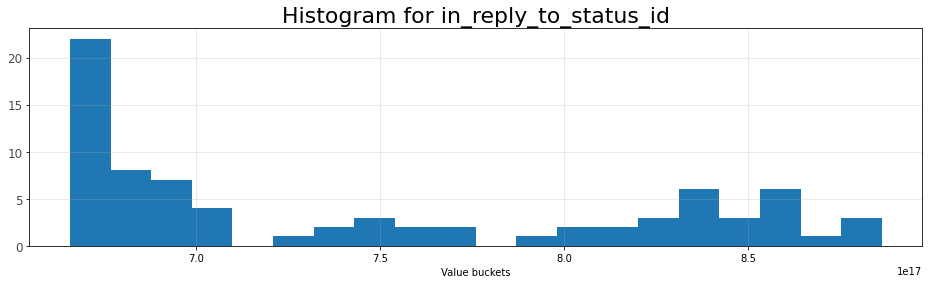

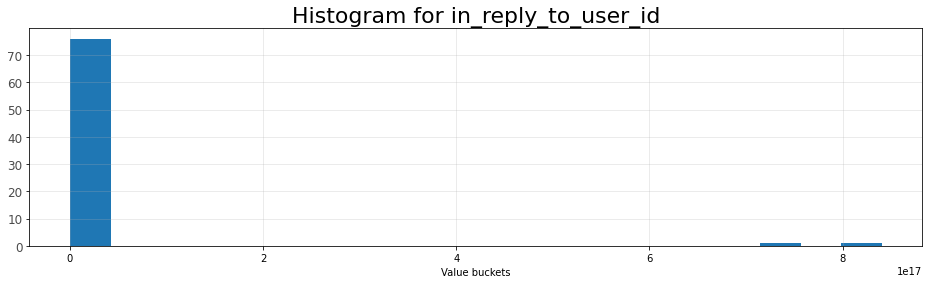

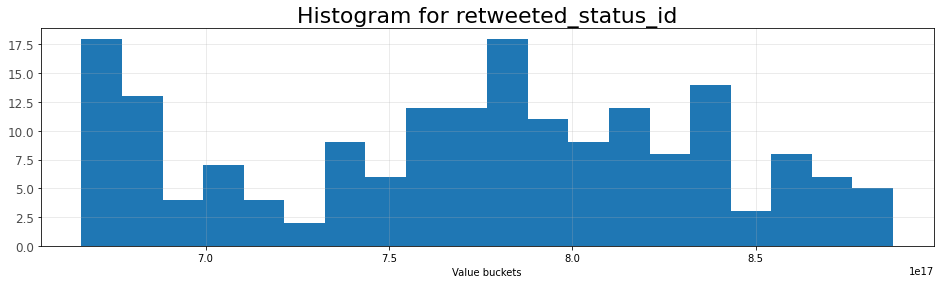

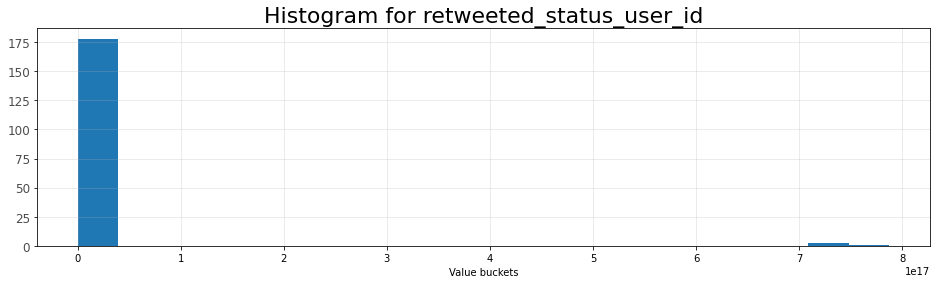

In [92]:
# Histograms for integer or float (numerical) fields providing statistical value distributions and visual data inspection for string columns in df_twitter_archive
list = []
for column in df_twitter_archive.columns:
    if str(df_twitter_archive[column].dtype) == "float64":
        list.append(column)
print(list)

for column in list:
    fig = plt.figure(figsize = (16,4))
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Value buckets')
    plt.title('Histogram for '+ column, fontsize=22)
    plt.grid(axis='both', alpha=.3)
    ax = fig.gca()
    df_twitter_archive[column].hist(ax = ax, bins=20)
    print('\n')

In [ ]:
# Histograms for integer or float (numerical) fields providing statistical value distributions and visual data inspection for string columns in df_tweet_image
list = []
for column in df_tweet_image.columns:
    if str(df_tweet_image[column].dtype) == "float64":
        list.append(column)
print(list)

for column in list:
    fig = plt.figure(figsize = (16,4))
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Value buckets')
    plt.title('Histogram for '+ column, fontsize=22)
    plt.grid(axis='both', alpha=.3)
    ax = fig.gca()
    df_tweet_image[column].hist(ax = ax, bins=20)
    print('\n')

['favorite_count', 'retweet_count', 'followers_count', 'friends_count', 'favourites_count']












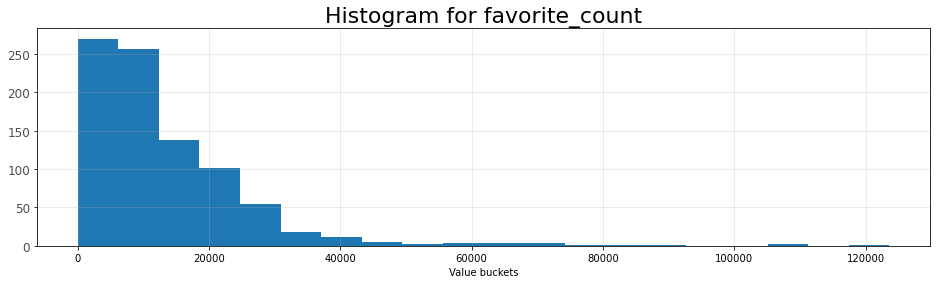

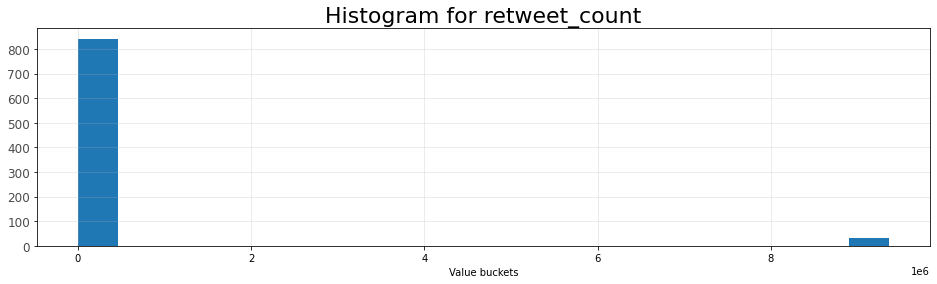

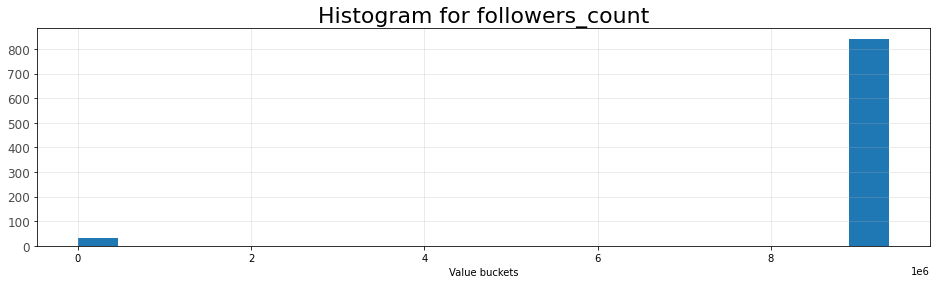

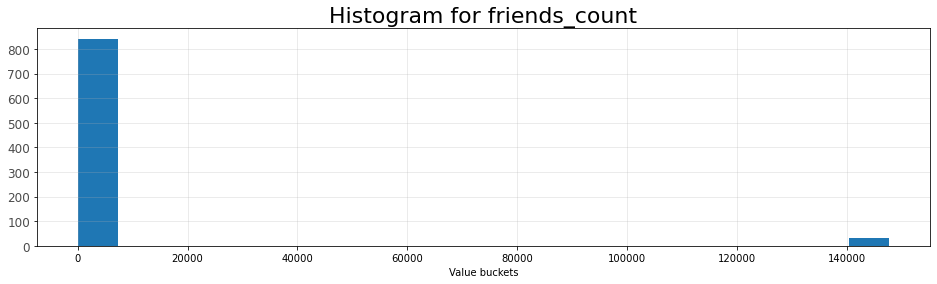

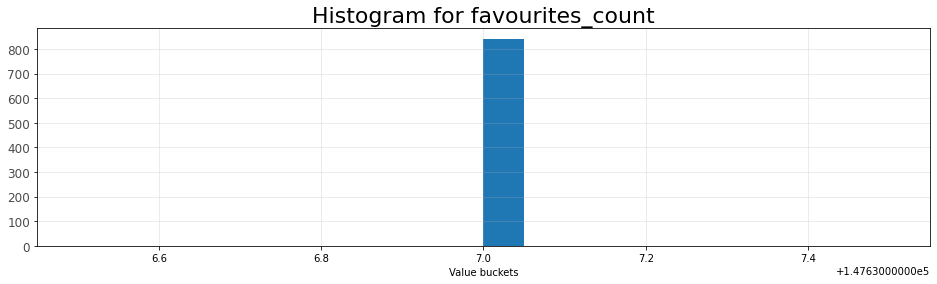

In [93]:
# Histograms for integer or float (numerical) fields providing statistical value distributions and visual data inspection for string columns in df_tweets_enhanced
list = []
for column in df_tweets_enhanced.columns:
    if str(df_tweets_enhanced[column].dtype) == "float64":
        list.append(column)
print(list)

for column in list:
    fig = plt.figure(figsize = (16,4))
    plt.yticks(fontsize=12, alpha=.7)
    plt.xlabel('Value buckets')
    plt.title('Histogram for '+ column, fontsize=22)
    plt.grid(axis='both', alpha=.3)
    ax = fig.gca()
    df_tweets_enhanced[column].hist(ax = ax, bins=20)
    print('\n')

### Histogram Obserations
1. We see a clear decline in the tpX_conf (confidence) values as they go from high order to low order ML assessment.
2. Favorite_count is right skewed toward lower numbers.
2. The amount of retweets is rather low compared to the larger dataset.

### Quality issues
1. After merge, 281 rows do not have corrosponding dog details.  This should be the core data set under analysis (combined)  ACTION: Remove subset as defined in the Assess Data.

2. Find and update incorrect ratings ACTION: Review and Correct each instance (few instances)
3. There are up to 181 retweets to be removed per the assignment guidance.  ACTION: Remove subset as defined in the Assess Data.  Drop unneeded columns.

4. [****Favorite_count / Retweet_count / Friends_count / Followers_count / Favorites_count****] have only 842 non-null values.  ACTION: Correct the Null / NaN to 0 values

5. Correct data types for tpX_conf columns to float, correct datatype for timestamp, correct data types for type string, Retweeted_status_timestamp

6. Ratings with decimal values incorrectly extracted ACTION: Take Corrective Actions

7. Dog breeds can be standardized ACTION: Standardize Names for tp1, tp2, tp3 ACTION: Align the breeds and ensure correct categorization.

8. Remove unneeded columns after cleanup - ***['doggo', 'floofer', 'pupper', 'puppo', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id','text_y']***  ACTION: Remove

### Tidiness issues
1. All Columns need to be merged to form a complete dataset and comply with tidiness standard. ACTION: Merge these.
2. Four dog stages are seperate and not easily visualized.  ACTION: Combine and clean originating columns.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

**NOTE:** Data was merged on '***tweet_id***' as part of the assessment.

#### Drop NULL Function

In [ ]:
# Define a Drop Nulls function
def drop_null_and_test_column(column_to_drop):
    #Remove Duplicates on 'ID'
    df_clean.dropna(subset = column_to_drop, how = 'any', inplace = True)
    
    #retest the result, this should equal 1
    nulls = (df_clean[column_to_drop].isnull())
    nulls = sum(nulls == True)
    return nulls

#### Drop Duplicates Function

In [ ]:
# Define a Drop duplicates function
def drop_duplicates_and_test_column(column_to_drop):
    #Remove Duplicates on 'ID'
    df_clean.drop_duplicates(subset = column_to_drop, keep = 'last', inplace = True)
    
    #retest the result, this should equal 1
    duplicates = (df_clean.duplicated(subset=[column_to_drop], keep='last'))
    duplicates = sum(duplicates == True)
    return duplicates

### Tideiness Issue #1:  All Columns need to be merged to form a complete dataset and comply with tidiness standard. ACTION: Merge these.

#### Code

In [ ]:
# Join df_twitter_archive and df_tweets_enhanced tables to analysis (MOVE TO CLEANUP)

# Remove Truncation of records for accurate of EDA Work
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 130)

# First we join Twitter_archive and Twitter Image Analysis with an outer join
df_twitter_merged = df_twitter_archive.copy()
df_twitter_merged['tweet_id'] = df_twitter_merged['tweet_id'].astype('str')
df_twitter_merged = df_twitter_merged.merge(df_tweet_image, how="outer", on='tweet_id')

# Clean df_tweets_enhanced (scraped data for a clean join)
# Rename for consistency and join
df_tweets_enhanced.rename(columns={"id_str": "tweet_id"}, inplace=True)
# Define regex to find valid patterns
regex_string = r"^([0-9][0-9][0-9][0-9][0-9][0-9]*)"
# Drop non-valid values (possible result of scapeing JSON data)
df_tweets_enhanced.drop(df_tweets_enhanced[~df_tweets_enhanced["tweet_id"].str.contains(regex_string, na=False, regex=True)].index, inplace=True)
# Drop any Null values (possible result of scapeing JSON data)
df_tweets_enhanced.dropna(subset='tweet_id', inplace=True)


#Next we join the new consolidated df_twitter_merged and Twitter scraped data with an outer join
df_twitter_merged = df_twitter_merged.merge(df_tweets_enhanced, how="outer", on='tweet_id')


#### Test

In [ ]:
# Verify the merged size and columns are correct, showing missing data (MOVE TO CLEANUP)
print(df_twitter_merged.info())
print(df_twitter_merged.shape)

#### Copy cleaning Dataset

In [ ]:
# Make copies of original pieces of data

#NOTE: Data was merged on 'tweet_id' as part of the assessment. Each record contains one single Tweet and specific data about the Dog breed as it relates to Tweet ID.
# Make a copy of the data
df_clean = df_twitter_merged.copy()


### Issue #1:  After merge, 281 rows do not have corrosponding dog details. This should be the core data set under analysis (combined) ACTION: Remove subset as defined in the Assess Data.

In [ ]:
df_clean.info()

#### Code

In [ ]:
# Call drop Null function
print(drop_null_and_test_column('tjpg_url'))

#### Test

In [ ]:
# Should return a 0
nulls = (df_clean['tjpg_url'].isnull())
nulls = sum(nulls == True)
print(nulls)

### Issue #2: Find and update incorrect ratings ACTION: Review and Correct each instance (few instances)

#### Code

In [64]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

# Update '810984652412424192' with correct ratings
df_clean['rating_numerator'][df_clean['tweet_id'] == '810984652412424192'] = 0
df_clean['rating_denominator'][df_clean['tweet_id'] == '810984652412424192'] = 0
print('Updating 810984652412424192\n\n')

# Update '740373189193256964' with correct ratings
df_clean['rating_numerator'][df_clean['tweet_id'] == '740373189193256964'] = 14
df_clean['rating_denominator'][df_clean['tweet_id'] == '740373189193256964'] = 10
print('Updating 740373189193256964\n\n')

# Update '722974582966214656' with correct ratings
df_clean['rating_numerator'][df_clean['tweet_id'] == '722974582966214656'] = 13
df_clean['rating_denominator'][df_clean['tweet_id'] == '722974582966214656'] = 10
print('Updating 722974582966214656\n\n')

# Update '716439118184652801' with correct ratings
df_clean['rating_numerator'][df_clean['tweet_id'] == '716439118184652801'] = 11
df_clean['rating_denominator'][df_clean['tweet_id'] == '716439118184652801'] = 10
print('Updating 716439118184652801\n\n')

# Update '682962037429899265' with correct ratings
df_clean['rating_numerator'][df_clean['tweet_id'] == '682962037429899265'] = 10
df_clean['rating_denominator'][df_clean['tweet_id'] == '682962037429899265'] = 10
print('Updating 682962037429899265\n\n')

# Update '666287406224695296' with correct ratings
df_clean['rating_numerator'][df_clean['tweet_id'] == '666287406224695296'] = 9
df_clean['rating_denominator'][df_clean['tweet_id'] == '666287406224695296'] = 10
print('Updating 666287406224695296\n\n')



Updating 810984652412424192


Updating 740373189193256964


Updating 722974582966214656


Updating 716439118184652801


Updating 682962037429899265


Updating 666287406224695296




/var/folders/y3/3kgm4s_n6rd5n4q45fw20d3m0000gp/T/ipykernel_28176/2806342792.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['rating_numerator'][df_clean['tweet_id'] == '810984652412424192'] = 0
/var/folders/y3/3kgm4s_n6rd5n4q45fw20d3m0000gp/T/ipykernel_28176/2806342792.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['rating_denominator'][df_clean['tweet_id'] == '810984652412424192'] = 0
/var/folders/y3/3kgm4s_n6rd5n4q45fw20d3m0000gp/T/ipykernel_28176/2806342792.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

#### Test

In [65]:
df_clean[df_clean['rating_denominator'] != 10][['tweet_id', 'text_x', 'rating_numerator', 'rating_denominator']]
#df_clean.rating_denominator.value_counts()

,tweet_id,text_x,rating_numerator,rating_denominator
323,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70
385,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7
662,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150
800,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11
848,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170
891,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20
925,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50
946,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90
970,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80
988,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50


### Issue #3  There are up to 181 retweets to be removed per the assignment guidance. ACTION: Remove subset as defined in the Assess Data.  Drop unneeded columns.

#### Code & Test

In [ ]:
# Remove Retweets
# Reset Index Variable
index_remove = []

print('Removing Retweet records\n')
index_remove = df_clean[(~df_clean['retweeted_status_id'].isnull())].index
df_clean.drop(index_remove, inplace=True)
print('Removed {} rows for False values'.format(len(index_remove)))


### Issue #4  [***favorite_count,  retweet_count, friends_count, followers_count, favorites_count***] have only 842 non-null values.  ACTION: Correct the Null / NaN to 0 values


#### Code

In [ ]:
# Turn NaN to 0 values
column_list = ['favorite_count', 'retweet_count', 'friends_count', 'followers_count', 'favourites_count']
for column in column_list:
    df_clean[column] = df_clean[column].replace(np.nan, 0)

#### Test

In [ ]:
# Show Null Values, should show 0 (x5)
column_list = ['favorite_count', 'retweet_count', 'friends_count', 'followers_count', 'favourites_count']
for column in column_list:
    print(df_clean[df_clean[column].isnull()][column].count())



### Issue #5 Correct data types for tpX_conf columns to float, correct datatype for timestamp, correct data types for type string, Retweeted_status_timestamp

#### Code

In [ ]:
#Change Timestamp to Date for processsing later, and Clean up variable types
df_clean['retweeted_status_timestamp'] = pd.to_datetime(df_clean['retweeted_status_timestamp'], format='%Y-%m-%d')
df_clean['tp1_conf'] = df_clean['tp1_conf'].replace('', np.NaN).astype(float)
df_clean['tp2_conf'] = df_clean['tp2_conf'].replace('', np.NaN).astype(float)
df_clean['tp3_conf'] = df_clean['tp3_conf'].replace('', np.NaN).astype(float)

#### Test

In [ ]:
df_clean[['retweeted_status_timestamp', 'tp1_conf', 'tp2_conf', 'tp3_conf']].info()

### Issue #6:  Ratings with decimal values incorrectly extracted ACTION: Take Corrective Actions

#### Code

In [67]:
regex_string = '^.*[^$]([0-9]{1,5}\.[0-9]{1,3}[\/]).*$'
# Change to String
df_clean['rating_numerator'] = df_clean['rating_numerator'].astype(str)
# Extract Raw float with '/' for rows in scope
df_clean['rating_numerator'][df_clean['text_x'].str.match(regex_string) == True] = df_clean['text_x'].str.extract(regex_string, expand = False).astype(str)
# Remove '/' and change to float for 4 impacted entries
df_clean['rating_numerator'] = df_clean['rating_numerator'].str.replace("/", '')
# Correct types for the two ratings values
df_clean['rating_numerator'] = df_clean['rating_numerator'].astype(float)
df_clean['rating_denominator'] = df_clean['rating_denominator'].astype(float)


/var/folders/y3/3kgm4s_n6rd5n4q45fw20d3m0000gp/T/ipykernel_28176/2011457515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['rating_numerator'][df_clean['text_x'].str.match(regex_string) == True] = df_clean['text_x'].str.extract(regex_string, expand = False).astype(str)


#### Test

In [68]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 500)

#Should return 4 rows with correct values.
regex_string = '^.*[^$]([0-9]{1,5}\.[0-9]{1,3}[\/]).*$'
df_clean[['tweet_id', 'text_x', 'rating_numerator']][df_clean['text_x'].str.contains(regex_string) == True]


/var/folders/y3/3kgm4s_n6rd5n4q45fw20d3m0000gp/T/ipykernel_28176/3637057821.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_clean[['tweet_id', 'text_x', 'rating_numerator']][df_clean['text_x'].str.contains(regex_string) == True]


,tweet_id,text_x,rating_numerator
39,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",3.50
503,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
553,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,1.27
1374,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,1.26


### Issue #7: Dog breeds can be standardized ACTION: Standardize Names for tp1, tp2, tp3 ACTION: Align the breeds and ensure correct categorization.

#### Code

In [69]:
# Standardize capitalized values to lower
df_clean['tp1'] = df_clean['tp1'].str.lower()
df_clean['tp2'] = df_clean['tp2'].str.lower()
df_clean['tp3'] = df_clean['tp3'].str.lower()


#### Test

In [70]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
print(df_clean.tp1.value_counts())

golden_retriever                  139
labrador_retriever                 95
pembroke                           88
chihuahua                          79
pug                                54
chow                               41
samoyed                            40
toy_poodle                         38
pomeranian                         38
malamute                           29
cocker_spaniel                     27
french_bulldog                     26
chesapeake_bay_retriever           23
miniature_pinscher                 22
seat_belt                          21
siberian_husky                     20
german_shepherd                    20
staffordshire_bullterrier          19
eskimo_dog                         18
maltese_dog                        18
shetland_sheepdog                  18
teddy                              18
beagle                             17
shih-tzu                           17
cardigan                           17
rottweiler                         17
italian_grey

### Tideiness Issue #2 Four dog stages are seperate and not easily visualized.  ACTION: Combine and clean originating columns.

#### Code

In [ ]:
# Four Dog Stages Combine
column_list = ['doggo', 'floofer', 'pupper', 'puppo']

# Remove all None values to NaN
print('Replacing None Values')
for column in column_list:
    df_clean[column] = df_clean[column].replace('None', '')

print('Creating new column and cleaning')
# Create new combined column
df_clean['dog_stage'] = df_clean['doggo'] +'|'+ df_clean['floofer'] +'|'+ df_clean['pupper'] +'|'+ df_clean['puppo']
df_clean['dog_stage'] = df_clean['dog_stage'].replace('|||', 'None')

print('New Column Created')

#Insert Regex code to clean up double values
# Traverse down by Right to Left to pick the last item
regex_string = '^.*(puppo).*$'
print(regex_string)
df_clean['dog_stage'][df_clean['dog_stage'].str.contains(regex_string) == True] = 'puppo'
print('puppo is extracted')

regex_string = '^.*(pupper).*$'
print(regex_string)
df_clean['dog_stage'][df_clean['dog_stage'].str.contains(regex_string) == True] = 'pupper'
print('pupper is extracted')

regex_string = '^.*(floofer).*$'
print(regex_string)
df_clean['dog_stage'][df_clean['dog_stage'].str.contains(regex_string) == True] = 'floofer'
print('floofer is extracted')

regex_string = '^.*(doggo).*$'
print(regex_string)
df_clean['dog_stage'][df_clean['dog_stage'].str.contains(regex_string) == True] = 'doggo'
print('doggo is extracted')

#### Test

In [71]:
df_clean['dog_stage'].value_counts()

None       1688
pupper      212
doggo        63
puppo        23
floofer       8
Name: dog_stage, dtype: int64

### Issue #8:  Remove unneeded columns after cleanup - ['doggo', 'floofer', 'pupper', 'puppo', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id','text_y']  ACTION: Remove

#### Code

In [ ]:
# Finally remove all unneeded columns
unneeded_columns = ['doggo', 'floofer', 'pupper', 'puppo', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id','text_y']
print('Removing unneeded columns')
df_clean.drop(unneeded_columns, axis=1, inplace=True)


#### Test

In [72]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp           1994 non-null   object 
 2   source              1994 non-null   object 
 3   text_x              1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   float64
 6   rating_denominator  1994 non-null   float64
 7   name                1994 non-null   object 
 8   tjpg_url            1994 non-null   object 
 9   timg_num            1994 non-null   int64  
 10  tp1                 1994 non-null   object 
 11  tp1_conf            1994 non-null   float64
 12  tp1_dog             1994 non-null   bool   
 13  tp2                 1994 non-null   object 
 14  tp2_conf            1994 non-null   float64
 15  tp2_dog             1994 non-null   bool   
 16  tp3   

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [73]:
# Save clean dataframe to twitter_archive_master.csv
df_clean.to_csv('twitter_archive_master.csv', index=False)
print('File Written, file size is {} Kb'.format((os.path.getsize('twitter_archive_master.csv')/1000)))


File Written, file size is 1064.676 Kb


In [63]:
#Reload Data
df_clean = pd.read_csv('twitter_archive_master.csv')
#df_clean.drop('Unnamed: 0', axis=1)

## Analyzing and Visualizing Data (UPDATE)
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [74]:
# Get Standard values for all numerical columns 
df_clean.describe()

,tweet_id,rating_numerator,rating_denominator,timg_num,tp1_conf,tp2_conf,tp3_conf,favorite_count,retweet_count,followers_count,friends_count,favourites_count
count,1.994000e+03,1994.000000,1994.000000,1994.000000,1994.000000,1.994000e+03,1.994000e+03,1994.000000,1994.000000,1.994000e+03,1994.000000,1994.000000
mean,7.358508e+17,12.222056,10.532096,1.203109,0.593941,1.344195e-01,6.024848e-02,5301.640421,1364.482447,3.038529e+06,6.813942,47904.282347
std,6.747816e+16,41.473091,7.320710,0.560777,0.271954,1.006807e-01,5.089067e-02,10813.044919,3340.413852,4.385346e+06,9.834199,69137.699326
min,6.660209e+17,0.000000,2.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,6.758475e+17,10.000000,10.000000,1.000000,0.362857,5.393987e-02,1.619283e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,7.084748e+17,11.000000,10.000000,1.000000,0.587635,1.174550e-01,4.950530e-02,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,7.877873e+17,12.000000,10.000000,1.000000,0.846285,1.951377e-01,9.159438e-02,7901.500000,1816.500000,9.364491e+06,21.000000,147637.000000
max,8.924206e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,123592.000000,51372.000000,9.364492e+06,21.000000,147637.000000


Perfect Ratings are 419, this represents 21.013039117352054% of the sample data.

Less than perfect Ratings are 417, this represents 20.91273821464393% of the sample data.

More than perfect Ratings are 1158, this represents 58.07422266800402% of the sample data.

INSIGHT / CONCLUSION: Based on this, ratings are heavily left skewed when visualized.  This colunn is a completely subjective measure of the humor.  This is intentional per the site.

See: https://knowyourmeme.com/memes/theyre-good-dogs-brent


/var/folders/y3/3kgm4s_n6rd5n4q45fw20d3m0000gp/T/ipykernel_28176/2782732725.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distribution = distribution.append({'less_than_perfect': less_than_perfect, 'perfect': perfect, 'more_than_perfect': more_than_perfect, }, ignore_index=True)


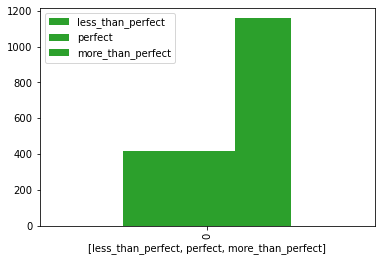

In [79]:
# Insight 1: Analysis of the rating system effectiveness (rating_numerator)
total = df_clean['rating_numerator'].count()
less_than_perfect = df_clean[df_clean['rating_numerator'] < 10].rating_numerator.count() 
less_than_perfect_percent = (less_than_perfect/total)*100
perfect = df_clean[df_clean['rating_numerator'] == 10].rating_numerator.count() 
perfect_percent = (perfect/total)*100
more_than_perfect = df_clean[df_clean['rating_numerator'] > 10].rating_numerator.count() 
more_than_perfect_percent = (more_than_perfect/total)*100
print('Perfect Ratings are {}, this represents {}% of the sample data.\n'.format(perfect, perfect_percent))
print('Less than perfect Ratings are {}, this represents {}% of the sample data.\n'.format(less_than_perfect, less_than_perfect_percent))
print('More than perfect Ratings are {}, this represents {}% of the sample data.\n'.format(more_than_perfect, more_than_perfect_percent))
print('INSIGHT / CONCLUSION: Based on this, ratings are heavily left skewed when visualized.  This colunn is a completely subjective measure of the humor.  This is intentional per the site.\n')
print('See: https://knowyourmeme.com/memes/theyre-good-dogs-brent')

# Build new dataframe
labels = ['less_than_perfect', 'perfect', 'more_than_perfect']
distribution = pd.DataFrame(columns=labels)
distribution = distribution.append({'less_than_perfect': less_than_perfect, 'perfect': perfect, 'more_than_perfect': more_than_perfect, }, ignore_index=True)

#Data Visualization
distribution.plot(kind = 'bar', xlabel = labels, color='tab:green')
plt.show;


In [98]:
# Finer analysis of the standard values for this important categrical value (rating_numerator)
df_clean['rating_numerator'].describe()


count   1,994
mean       12
std        41
min         0
25%        10
50%        11
75%        12
max     1,776
Name: rating_numerator, dtype: float64

### Visualization (UPDATE)

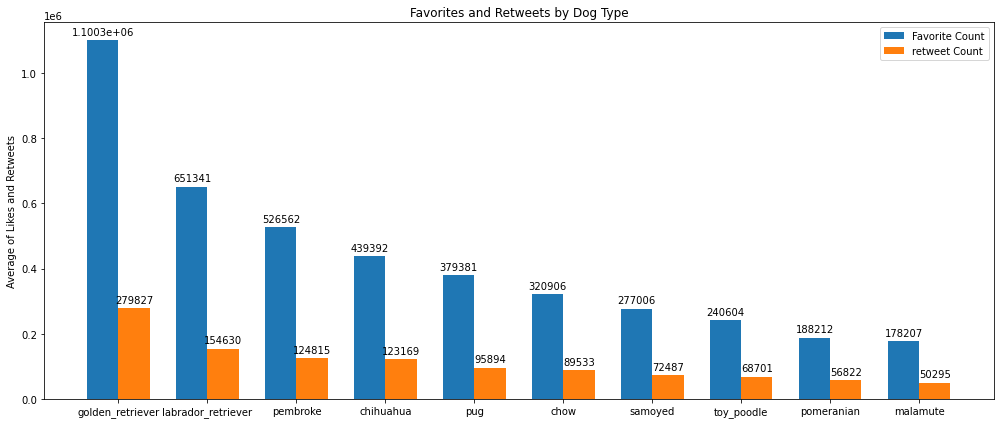

In [94]:
# Draw Plot profit analysis by production_company(see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)

# Set Number Display format
pd.options.display.float_format = '{:,.0f}'.format

# Setup Chart Values
favorite_count_data = df_clean[df_clean['tp1'] != 'None'].sort_values('favorite_count').groupby(by=["tp1"]).favorite_count.sum().nlargest(10)
retweet_count_data = df_clean[df_clean['tp1'] != 'None'].sort_values('favorite_count').groupby(by=["tp1"]).retweet_count.sum().nlargest(10)
labels = df_clean['tp1'].value_counts().nlargest(10).index.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Set the subplots
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, favorite_count_data, width, label='Favorite Count')
rects2 = ax.bar(x + width/2, retweet_count_data, width, label='retweet Count')

# Set visual variables
ax.set_ylabel('Average of Likes and Retweets')
ax.set_title('Favorites and Retweets by Dog Type')
ax.set_xticks(x);ax.set_xticklabels(labels)
ax.legend()
fig.set_size_inches(14,6)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show();

### Chart Obserations
1. We clearly see the favorite dogs in the ratings based on favorite count and retweet count based on mean (mean shows this also with a similar trend).  Retrievers are a clear favorite here, representing almost 1/5 of the overall Favorites data.
3. Dog Breed data is based on the ML learning model, so there is a margin of error.  The engine does have some gaps in identification, classifying the primary subject in the photos (sometimes an inanimate object).  See the final conclusions for more context.

In [119]:
# Finer analysis of the values for this important categrical value (tp1)
pd.options.display.float_format = '{:,.0f}'.format
print('\nWith Retiever\n')
print(df_clean[df_clean['tp1'].str.contains('retriever') == True][['favorite_count', 'retweet_count']].sum())
print('\nWithout Retiever')
print(df_clean[df_clean['tp1'].str.contains('retriever') == False][['favorite_count', 'retweet_count']].sum())
# Group by .groupby(by=["tp1"])




With Retiever

favorite_count   1,906,973
retweet_count      470,415
dtype: float64

Without Retiever
favorite_count   8,664,498
retweet_count    2,250,363
dtype: float64


In [82]:
# Finer analysis of the standard values for this important categrical value (tp1)
# Set Number Display format
pd.options.display.float_format = '{:,.4f}'.format
df_clean.groupby(by=["tp1"])['tp1_conf'].describe().sort_values('max', ascending = False).describe()


,count,mean,std,min,25%,50%,75%,max
count,374.0000,374.0000,198.0000,374.0000,374.0000,374.0000,374.0000,374.0000
mean,5.3316,0.5280,0.2255,0.3855,0.4590,0.5284,0.5990,0.6620
std,12.1053,0.2347,0.1068,0.2652,0.2417,0.2493,0.2666,0.2953
min,1.0000,0.0811,0.0089,0.0443,0.0632,0.0811,0.0811,0.0811
25%,1.0000,0.3460,0.1571,0.1744,0.2741,0.3332,0.3811,0.4023
50%,2.0000,0.5134,0.2340,0.2920,0.4032,0.5008,0.6095,0.7299
75%,4.0000,0.6832,0.2904,0.5326,0.6097,0.7089,0.8284,0.9500
max,139.0000,0.9999,0.5356,0.9999,0.9999,0.9999,0.9999,1.0000


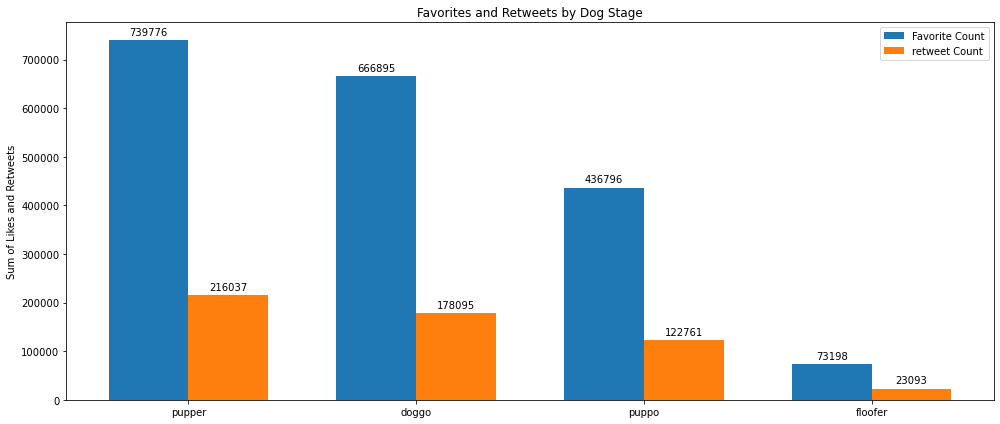

In [96]:
# Draw Plot profit analysis by production_company(see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)

# Set Number Display format
pd.options.display.float_format = '{:,.0f}'.format

# Setup Chart Values
favorite_count_data = df_clean[df_clean['dog_stage'] != 'None'].groupby(by=["dog_stage"]).favorite_count.sum().nlargest(4)
retweet_count_data = df_clean[df_clean['dog_stage'] != 'None'].groupby(by=["dog_stage"]).retweet_count.sum().nlargest(4)
labels = df_clean[df_clean['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Set the subplots
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, favorite_count_data, width, label='Favorite Count')
rects2 = ax.bar(x + width/2, retweet_count_data, width, label='retweet Count')

# Set visual variables
ax.set_ylabel('Sum of Likes and Retweets')
ax.set_title('Favorites and Retweets by Dog Stage')
ax.set_xticks(x);ax.set_xticklabels(labels)
ax.legend()
fig.set_size_inches(14,6)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show();

### Histogram Obserations:
1. The dog_stage dimension does appear to be a corelating variable for popularity, when we review the sum and average.
2. doggo represents almost the same sum totals as pupper, though from a population distribution they represent approx 75% less of this categorical value. 
3. The median value between the top two pupper and doggo is a similar ratio to sum, but the mean is far less for doggo.  Per the describe outputs, doggo values have a lower distribution and higher standard values (mean, 50%, 75%)
4. The same comments above could be said for the puppo stage, where the population count is 10% of pupper, but all standard values are well above any other group and sum popularity still reaches more than 50% of pupper.

In [86]:
# Finer analysis of the standard values for this important categrical value (dog_stage)
df_clean[df_clean['dog_stage'] != 'None'].groupby(by=["dog_stage"])[['favorite_count', 'retweet_count',]].describe()


favorite_count                                             retweet_count                                       
                   count   mean    std min 25%    50%    75%     max         count  mean   std min 25%   50%   75%    max
dog_stage                                                                                                                
doggo                 63 11,742 14,216   0   0  9,841 14,894  82,356            63 3,429 5,629   0   0 2,006 3,783 34,387
floofer                8  9,150 10,941   0   0  5,282 16,061  27,976             8 2,887 4,946   0   0 1,312 2,852 14,625
pupper               212  3,146  9,568   0   0      0      0 108,435           212   840 2,693   0   0     0     0 30,039
puppo                 23 18,991 27,298   0   0 13,305 18,748 123,592            23 5,337 8,846   0   0 2,445 5,976 39,718

### Insights:
1. Ratings values are heavily left skewed when visualized.  The 25%th percentile starts at a value of 10 (perfect).  This colunn is a completely subjective measure of the humor; this is intentional per the sites guidelines and mission.

2. Per the first visualization, the retrievers (golden and Labrador) are the most liked and retweeted by the numbers (around 19%). It should be noted, the breed was derived from an ML model, trained with a dog photo, and common objects data set. There appears to be a variation in the tp1_conf values. We see an overall standard deviation of 0.1068 and a variance between 25th and 75th percentile of 0.5543 (a 55% spread).  Practically speaking, this should be taken in consideration when reviewing this observation, and only a manual assessment would provide conclusive proof. In some cases (derived through manual inspection) a background or prop stood out it was identified and named, the dog was in the photo but not identified.

3. The dog_stage dimension does appear to be a corelating variable for popularity, when we review the sum and average. doggo represents almost the same sum totals as pupper, though from a population distribution they represent approximately 75% less of this categorical value. The median value between the top two pupper and doggo is a similar ratio to sum, but the mean is far less (for doggo). Per the describe outputs, doggo values have a lower distribution and higher standard values (mean, 50%, 75%). The same comments above could be said for the puppo stage, where the population count is 10% of pupper, but all standard values are well above any other group and sum popularity still reaches more than 50% of pupper numbers. Bottom line, this categorical value, has some very interesting population distribution statistics, as they relate to overall impact on popularity.